## Grab the train and test

In [ ]:
!pip install kaggle ## As only needed to fetch data, not included in requirements.txt

### Go to kaggle account, and create a new token. It should download a json, upload it when running the next cell.

In [40]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reckerdev","key":"fa5b0322fb5320c61a73e9102ad094c1"}'}

In [41]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [42]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 91% 65.0M/71.5M [00:00<00:00, 91.7MB/s]
100% 71.5M/71.5M [00:00<00:00, 98.7MB/s]


## Import Deps and Device Config

In [43]:
import os
# import zipfile

In [44]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import dataloader,DataLoader
import matplotlib.pyplot as plt

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Create Custom DataSet class

In [49]:
train_dir = "/content/dataset/Combined Dataset/train"
test_dir = "/content/dataset/Combined Dataset/test"


#### Data Transformation

In [51]:
# Transform for training dataset
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),               # Resize to 128x128
    transforms.ToTensor(),                       # Convert image to PyTorch tensor
])

# Transform for test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [53]:
## Loading the dataset

train_dataset = ImageFolder(root=train_dir,transform=train_transform)
test_dataset = ImageFolder(root=test_dir,transform=test_transform)

In [54]:
# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

 Build the CNN Model

In [56]:
class AlzheimerDetector(nn.Module):
  """
  Model Arch replicates TinyVGG model
  from CNN explainer website

  """

  def __init__(self, input_shape:int, hidden_units:int, output_shape:int,image_dimension:int):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2=nn.Sequential(
    nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*image_dimension//2//2*image_dimension//2//2,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))



In [57]:
torch.manual_seed(42)
model=AlzheimerDetector(input_shape=3,
                            hidden_units=10,
                            output_shape=4,
                            image_dimension=128).to(device)

model

AlzheimerDetector(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=4, bias=True)
  )
)

In [59]:
## Load a sample image from train dataloader
sample_batch,sample_label=next(iter(train_loader))
sample_batch.shape

torch.Size([32, 3, 128, 128])

In [60]:
image = torch.randn(32,3,128,128)

conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=10,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=10,
                  out_channels=10,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

conv_block_2=nn.Sequential(
    nn.Conv2d(in_channels=10,
                  out_channels=10,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=10,
                  out_channels=10,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )
classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=10*32*32,
                  out_features=4)
    )

print(image.shape)
print(conv_block_1(image).shape)
print(conv_block_2(conv_block_1(image)).shape)
print(classifier(conv_block_2(conv_block_1(image))).shape)

torch.Size([32, 3, 128, 128])
torch.Size([32, 10, 64, 64])
torch.Size([32, 10, 32, 32])
torch.Size([32, 4])


## Get Helper Functions

In [61]:
import requests
import os

if os.path.exists("helper_functions.py"):
  print("Skipping download, helper_functions.py exists!")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Skipping download, helper_functions.py exists!


In [62]:
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn, print_train_time

## Train-Test Loop time Functions

In [63]:
train_loss_arr=[]
test_loss_arr=[]

train_acc_arr=[]
test_acc_arr=[]

In [64]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               accuracy_fn:accuracy_fn):

  """Performs a training with model trying to learn on data_loader"""

  train_loss,train_acc=0,0
  model.train()



    ## Training
  train_loss=0 ## for calculating training_loss per batch

    ## Add a loop to loop through the training batches
  for batch,(X,y) in enumerate(dataloader):

    X,y=X.to(device),y.to(device)

      ## Forward pass
    y_pred=model(X)

      ## Calc the loss(per batch)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    train_acc+=accuracy_fn(y,y_pred.argmax(dim=1))

      ## Optimizer zero grad
    optimizer.zero_grad()

      ## Loss backward
    loss.backward()

      ## Optimizer step
    optimizer.step()



  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)

  print(f"\n Train Loss: {train_loss:.4f}  | Train Accuracy: {train_acc}")





In [65]:
def test_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device,
               accuracy_fn:accuracy_fn):

  """Performs a testing with model trying to learn on data_loader"""

  test_loss,test_acc=0,0
  model.eval()

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):

      X,y=X.to(device),y.to(device)

      ## Forward pass
      y_pred=model(X)

      ## Calc the loss(per batch)
      loss=loss_fn(y_pred,y)
      test_loss+=loss.item()
      test_acc+=accuracy_fn(y,y_pred.argmax(dim=1))

    test_loss/=len(dataloader)
    test_acc/=len(dataloader)
    test_loss_arr.append(test_loss)
    test_acc_arr.append(test_acc)

  print(f"\n Test Loss: {test_loss:.4f}  | Test Accuracy: {test_acc}")



In [66]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn=torch.nn.Module,
               accuracy_fn=accuracy_fn):
  """
  Returns a dictionary containing the results of model predicting on data_loader.
  """

  loss,acc=0,0

  model.eval()
  with torch.inference_mode():

    for X,y in data_loader:

      X,y=X.to(device),y.to(device)

      ## Forward pass
      y_pred=model(X)
      ## Calc the loss(per batch)
      loss+=loss_fn(y_pred,y)
      ## Calc the accuracy(per batch)
      acc+=accuracy_fn(y,y_pred.argmax(dim=1))

    ## Adjust metrics to get average loss and accuracy per batch
    loss=loss/len(data_loader)
    acc/=len(data_loader)


  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

## Setting up Loss function and optimizer

In [67]:
## Train the CNN on our dataset

## Setup loss func, eval metrics, optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),
                          lr=0.001)


In [68]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
from tqdm.auto import tqdm ## For progress bar

epochs=20

train_time_on_device_start=timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")


  train_step(model=model,
             dataloader=train_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device,
             accuracy_fn=accuracy_fn)

  test_step(model=model,
            dataloader=test_loader,
            loss_fn=loss_fn,
            device=device,
            accuracy_fn=accuracy_fn)


train_time_on_device_end=timer()

total_train_time_on_device=print_train_time(start=train_time_on_device_start,
                                         end=train_time_on_device_end,
                                         device=str(next(model.parameters()).device))


print(f"Train time on {device}: {total_train_time_on_device:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------

 Train Loss: 1.3885  | Train Accuracy: 24.39453125

 Test Loss: 1.3843  | Test Accuracy: 50.0
Epoch: 1
---------

 Train Loss: 1.2985  | Train Accuracy: 32.2265625

 Test Loss: 0.8672  | Test Accuracy: 61.28780241935484
Epoch: 2
---------

 Train Loss: 0.3823  | Train Accuracy: 84.013671875

 Test Loss: 0.5530  | Test Accuracy: 75.99546370967741
Epoch: 3
---------

 Train Loss: 0.2076  | Train Accuracy: 91.71875

 Test Loss: 0.3918  | Test Accuracy: 84.3523185483871
Epoch: 4
---------

 Train Loss: 0.1243  | Train Accuracy: 95.1953125

 Test Loss: 0.3476  | Test Accuracy: 86.30292338709677
Epoch: 5
---------

 Train Loss: 0.0874  | Train Accuracy: 96.865234375

 Test Loss: 0.3826  | Test Accuracy: 86.05594758064515
Epoch: 6
---------

 Train Loss: 0.0707  | Train Accuracy: 97.55859375

 Test Loss: 0.2975  | Test Accuracy: 89.03729838709677
Epoch: 7
---------

 Train Loss: 0.0405  | Train Accuracy: 98.59375

 Test Loss: 0.1924  | Test Accuracy: 93.27620967741936
Epoc

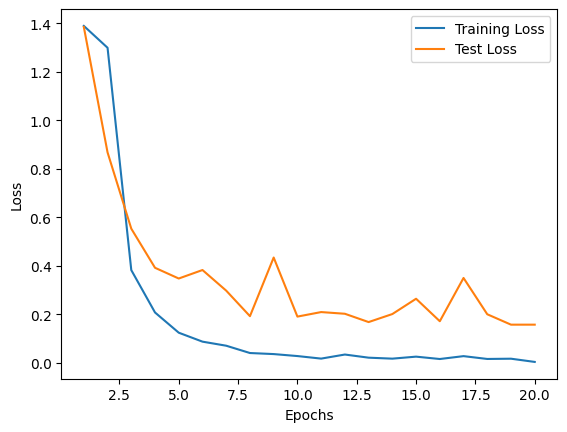

In [70]:
## Using the train-test loss array plot the loss over epochs

epochs_range = range(1, len(train_loss_arr)+1)

plt.plot(epochs_range, train_loss_arr, label='Training Loss')
plt.plot(epochs_range, test_loss_arr, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [71]:
## Model Performance on Train Data

eval_model(model=model,
           data_loader=test_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

{'model_name': 'AlzheimerDetector',
 'model_loss': 0.157427117228508,
 'model_acc': 95.46622983870968}

In [159]:
## Model Performance on Test Data

eval_model(model=model,
           data_loader=train_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

{'model_name': 'AlzheimerDetector',
 'model_loss': 0.003553879214450717,
 'model_acc': 99.90234375}

## Perform Model Metric Analysis

## Inferencing and Confusion Matrix

In [74]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.5 MB/s eta 0:00:00


In [173]:
import mlxtend
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [139]:
def make_predictions(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    y_preds = []
    y_true = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions..."):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logit = model(X)

            # Get prediction probabilities and predicted labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            # Collect predictions and true labels
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    # Combine all predictions and true labels into tensors
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


### Importing Deps for Confusion Matrix

In [134]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


### Train Data Confusion Matrix and Metrics

In [182]:
y_preds_train,y_true_train=make_predictions(model=model,
                 dataloader=train_loader)

Making predictions...: 100%|██████████| 320/320 [00:07<00:00, 40.25it/s]


In [183]:
confmat = ConfusionMatrix(num_classes=len(train_dataset.classes),
                          task="multiclass")

confmat_tensor=confmat(preds=y_preds_train,target=y_true_train)


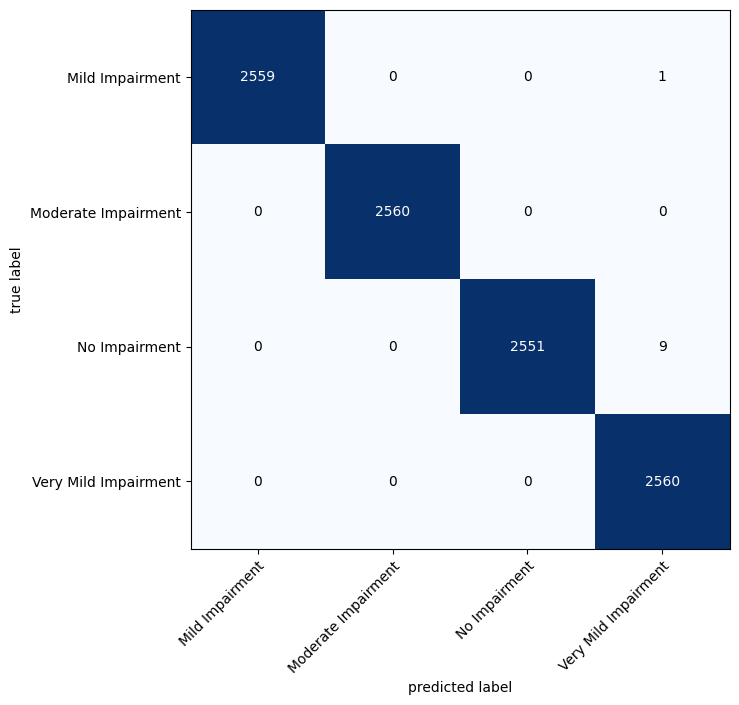

In [184]:
## Plot the confusion matrix

fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                           figsize=(10,7),
                           class_names=train_dataset.classes)
plt.show()

In [185]:
## Metrics

precision = precision_score(y_true_train, y_preds_train, average='weighted')
recall = recall_score(y_true_train, y_preds_train, average='weighted')
f1 = f1_score(y_true_train, y_preds_train, average='weighted')
accuracy=accuracy_score(y_true_train, y_preds_train)

print(f"Precision for Training Data: {precision:.4f}")
print(f"Recall for Training Data: {recall:.4f}")
print(f"F1-score for Training Data: {f1:.4f}")
print(f"Accuracy for Training Data: {accuracy:.4f}")

Precision for Training Data: 0.9990
Recall for Training Data: 0.9990
F1-score for Training Data: 0.9990
Accuracy for Training Data: 0.9990


### Test Data Confusion Matrix

In [186]:
y_preds_test,y_true_test=make_predictions(model=model,
                 dataloader=test_loader)

Making predictions...: 100%|██████████| 40/40 [00:01<00:00, 36.57it/s]


In [187]:
confmat = ConfusionMatrix(num_classes=len(test_dataset.classes),
                          task="multiclass")

confmat_tensor=confmat(preds=y_preds_test,target=y_true_test)


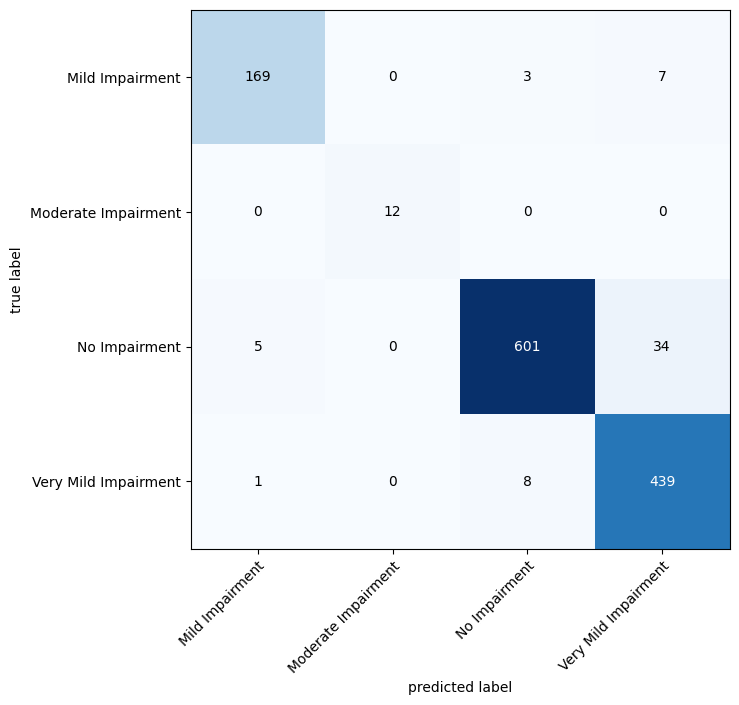

In [188]:
## Plot the confusion matrix

fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                           figsize=(10,7),
                           class_names=train_dataset.classes)
plt.show()

In [ ]:
## Metrics

precision = precision_score(y_true_test, y_preds_test, average='weighted')
recall = recall_score(y_true_test, y_preds_test, average='weighted')
f1 = f1_score(y_true_test, y_preds_test, average='weighted')
accuracy=accuracy_score(y_true_test, y_preds_test)


print(f"Precision for Testing Data: {precision:.4f}")
print(f"Recall for Testing Data: {recall:.4f}")
print(f"F1-score for Testing Data: {f1:.4f}")
print(f"Accuracy for Testing Data: {accuracy:.4f}")

Precision for Testing Data: 0.9563
Recall for Testing Data: 0.9547
F1-score for Testing Data: 0.9548
Accuracy for Training Data: 0.9547


## Saving the Model

In [170]:
import os

In [171]:
os.makedirs(os.path.join(os.getcwd(),"models"),exist_ok=True)
MODEL_NAME="alz_CNN.pt"
MODEL_PATH=os.path.join(os.getcwd(),"models",MODEL_NAME)

In [176]:
print(f"Saving model to: {MODEL_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_PATH)

Saving model to: /content/models/alz_CNN.pt


## Loading the Model

In [191]:
loaded_model=AlzheimerDetector(input_shape=3,hidden_units=10,output_shape=4,image_dimension=128).to(device)

In [193]:
loaded_model.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))

<All keys matched successfully>